# Online Multiclass Logistic Regression using CMGF

##0. Imports

In [ ]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging, sys, warnings, os

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [ ]:
try:
    from dynamax.cond_moments_gaussian_filter.cmgf import *
    from dynamax.cond_moments_gaussian_filter.containers import *
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    from dynamax.cond_moments_gaussian_filter.cmgf import *
    from dynamax.cond_moments_gaussian_filter.containers import *

In [ ]:
from warnings import simplefilter

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning

## 1. CMGF Model for Online Multiclass Logistic Regression

Note that the moments of a (one-hot-encoded) categorical distribution with $K$ possible classes are as follows:

$$\mathbb{E}[\vec{y}|\vec{x}, \textbf{W}] =  \begin{pmatrix} \sigma_2(\textbf{W}^T\vec{x}) \\ \sigma_3(\textbf{W}^T\vec{x}) \\ \vdots \\ \sigma_K(\textbf{W}^T\vec{x}) \end{pmatrix}
$$
$$Cov[\vec{y}|\vec{x}, \textbf{W}] = \begin{pmatrix} p_2 (1 - p_2) & -p_2 p_3 & \dots & -p_2 p_K \\
-p_2 p_3 & p_3 (1 - p_3) & \dots  & -p_3 p_K \\
\vdots & \vdots & \ddots & \vdots \\
-p_2 p_K & -p_3 p_K & \dots & p_K (1 - p_K)
 \end{pmatrix}$$
where $\vec{\sigma}(\cdot)$ is the softmax function.

Note that in order to prevent the "Dummy Variable Trap," we drop the first column.

Thus, we can build a generic multiclass CMGF classifier that works with the `scikit-learn` cross validation tool as follows.



In [ ]:
def fill_diagonal(A, elts):
    # Taken from https://github.com/google/jax/issues/2680
    elts = jnp.ravel(elts)
    i, j = jnp.diag_indices(min(A.shape[-2:]))
    return A.at[..., i, j].set(elts)

In [ ]:
class CMGFEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, params, mean=None, cov=None):
        self.params = params
        self.mean = mean
        self.cov = cov

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        # Encode output as one-hot-encoded vectors with first column dropped,
        # i.e., [0, ..., 0] correspondes to 1st class
        # This is done to prevent the "Dummy Variable Trap".
        enc = OneHotEncoder(drop='first')
        y_oh = jnp.array(enc.fit_transform(y.reshape(-1, 1)).toarray())
        input_dim = X_bias.shape[-1]
        num_classes = y_oh.shape[-1] + 1
        weight_dim = input_dim * num_classes
        
        initial_mean, initial_covariance = jnp.zeros(weight_dim), jnp.eye(weight_dim)
        dynamics_function = lambda w, x: w
        dynamics_covariance = jnp.zeros((weight_dim, weight_dim))
        emission_mean_function = lambda w, x: jax.nn.softmax(x @ w.reshape(input_dim, -1))[1:]
        def emission_var_function(w, x):
            ps = jnp.atleast_2d(emission_mean_function(w, x))
            return fill_diagonal(ps.T @ -ps, ps * (1-ps))
        cmgf_params = self.params(
            initial_mean = initial_mean,
            initial_covariance = initial_covariance,
            dynamics_function = dynamics_function,
            dynamics_covariance = dynamics_covariance,
            emission_mean_function = emission_mean_function,
            emission_var_function = emission_var_function
        )
        post = conditional_moments_gaussian_filter(cmgf_params, y_oh, inputs = X_bias)
        post_means, post_covs = post.filtered_means, post.filtered_covariances
        self.mean, self.cov = post_means[-1], post_covs[-1]
        return self
    
    def predict(self, X, y=None):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jnp.argmax(jax.nn.softmax(X_bias @ self.mean.reshape(X_bias.shape[-1], -1)), axis=1)

In [ ]:
# def repeated_kfold_cv(model, X, y, n_splits=10, n_repeats=3, key=1):
#     if isinstance(key, int):
#         key = jr.PRNGKey(key)
#     key, subkey = jr.split(key, 2)
#     num_points = len(y)
#     accuracy_score = 0
#     for _ in range(n_repeats):
#         idx = jr.permutation(key, jnp.arange(num_points))
#         kfolds = jnp.array_split(idx, n_splits)
#         for i in range(n_splits):
#             test_idx = kfolds[i]
#             train_idx = jnp.concatenate(kfolds[:i] + kfolds[i+1:])
#             X_train, y_train = X[train_idx], y[train_idx]
#             X_test, y_test = X[test_idx], y[test_idx]
#             model = model.fit(X_train, y_train)
#             y_predict = model.predict(X_test)
#             accuracy_score += 1 - (jnp.abs(y_predict - y_test).sum() / len(test_idx))
#     return accuracy_score / (n_splits * n_repeats)

##2. Accuracy Comparison with SGD

We compare classification accuracy of CMGF with those of one-pass SGD and multi-pass SGD using 10-fold cross validation.

In [ ]:
# # Helper function to compute accuracy measure
# def compute_accuracy(model, input, output, fit=True):
#     if fit:
#         model = model.fit(input, output)
#     return jnp.count_nonzero(model.predict(input) - output == 0) / len(output)

# # Print training accuracy
# cmgf_model, sgd_model = CMGFEstimator(EKFParams), LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1)
# print(f'CMGF training accuracy: {compute_accuracy(cmgf_model, input, output)}')
# print(f'SGD training accuracy: {compute_accuracy(sgd_model, input, output)}')

In [ ]:
def compute_cv_accuracies(num_points, num_classes):
    input, output = make_classification(n_samples=num_points, n_features=num_classes+1, 
                                        n_informative=num_classes+1, n_redundant=0, n_classes=num_classes, random_state=2)
    scaler = preprocessing.StandardScaler().fit(input)
    input, output = jnp.array(scaler.transform(input)), jnp.array(output)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

    cmgf_est = CMGFEstimator(EKFParams)

    cmgf_score = cross_val_score(cmgf_est, input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_op_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_mp_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag'), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()

    return cmgf_score, sag_op_score, sag_mp_score


In [ ]:
num_points = 1000
class_range = range(2, 19)

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    cmgf_ac, sgd_op_ac, sgd_mp_ac = compute_cv_accuracies(num_points, num_classes)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sag estimate average accuracy = {sgd_op_ac}')
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sag estimate average accuracy = {sgd_mp_ac}')
    

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.9040000000000001
One-pass sag estimate average accuracy = 0.89
Multi-pass sag estimate average accuracy = 0.905
1000 data points, 3 classes.
EKF-CMGF estimate average accuracy = 0.627
One-pass sag estimate average accuracy = 0.5710000000000001
Multi-pass sag estimate average accuracy = 0.628
1000 data points, 4 classes.
EKF-CMGF estimate average accuracy = 0.5499999999999999
One-pass sag estimate average accuracy = 0.48900000000000005
Multi-pass sag estimate average accuracy = 0.5489999999999998
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.48999999999999994
One-pass sag estimate average accuracy = 0.45199999999999996
Multi-pass sag estimate average accuracy = 0.483
1000 data points, 6 classes.
EKF-CMGF estimate average accuracy = 0.5640000000000001
One-pass sag estimate average accuracy = 0.519
Multi-pass sag estimate average accuracy = 0.5670000000000001
1000 data points, 7 classes.
EKF-CMGF est

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.35900000000000004
One-pass sag estimate average accuracy = 0.289
Multi-pass sag estimate average accuracy = 0.365
1000 data points, 13 classes.
EKF-CMGF estimate average accuracy = 0.33199999999999996
One-pass sag estimate average accuracy = 0.3
Multi-pass sag estimate average accuracy = 0.33999999999999997
1000 data points, 14 classes.
EKF-CMGF estimate average accuracy = 0.31100000000000005
One-pass sag estimate average accuracy = 0.28400000000000003
Multi-pass sag estimate average accuracy = 0.31900000000000006
1000 data points, 15 classes.
EKF-CMGF estimate average accuracy = 0.257
One-pass sag estimate average accuracy = 0.24899999999999997
Multi-pass sag estimate average accuracy = 0.261
1000 data points, 16 classes.
EKF-CMGF estimate average accuracy = 0.257
One-pass sag estimate average accuracy = 0.24500000000000002
Multi-pass sag estimate average accuracy = 0.272
1000 data points, 17 classes.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.2840000000000001
One-pass sag estimate average accuracy = 0.29
Multi-pass sag estimate average accuracy = 0.291
1000 data points, 18 classes.
EKF-CMGF estimate average accuracy = 0.257
One-pass sag estimate average accuracy = 0.225
Multi-pass sag estimate average accuracy = 0.25600000000000006


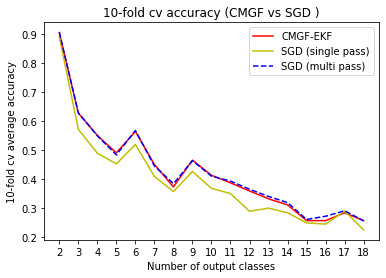

In [ ]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel('10-fold cv average accuracy')
ax.set_title('10-fold cv accuracy (CMGF vs SGD )')
ax.legend();

##3. Speed Comparison with SGD

In [ ]:
data_size_grid = list(range(20, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000)) \
                 + list(range(10000, 100000, 10000)) + list(range(100000, 1000000, 100000))

In [ ]:
cmgf_est = CMGFEstimator(EKFParams)
sgd_op_est = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1)
sgd_mp_est = LogisticRegression(multi_class='multinomial', solver='sag')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 20
cmgf took 1.4351356029510498 seconds.
one-pass sgd took 0.003902435302734375 seconds.
multi-pass sgd took 0.002874612808227539 seconds.
dataset of size 40
cmgf took 1.1339151859283447 seconds.
one-pass sgd took 0.004061222076416016 seconds.
multi-pass sgd took 0.002923250198364258 seconds.
dataset of size 60
cmgf took 1.0704281330108643 seconds.
one-pass sgd took 0.0029878616333007812 seconds.
multi-pass sgd took 0.002113819122314453 seconds.
dataset of size 80
cmgf took 0.9837203025817871 seconds.
one-pass sgd took 0.002657175064086914 seconds.
multi-pass sgd took 0.002251148223876953 seconds.
dataset of size 100
cmgf took 1.041109561920166 seconds.
one-pass sgd took 0.0031430721282958984 seconds.
multi-pass sgd took 0.004430055618286133 seconds.
dataset of size 200
cmgf took 1.1492512226104736 seconds.
one-pass sgd took 0.003290414810180664 seconds.
multi-pass sgd took 0.008254766464233398 seconds.
dataset of size 300
cmgf took 1.12516188621521 seconds.
one-pass sg

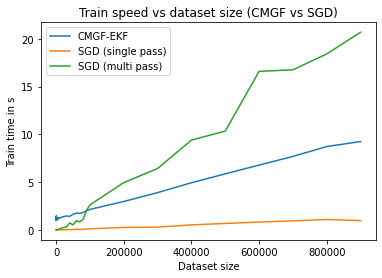

In [ ]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

##4. (K-1) CMGF Binary Regressions

Let us try to construct the multinomial logistic regression as a combination of $(K-1)$ binary logistic regressions.

In [ ]:
sigmoid_fn = lambda w, x: jax.nn.sigmoid(w @ x)

class CMGFOneVsAllEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, params, weights=None):
        self.params = params
        self.weights = weights

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        input_dim = X_bias.shape[-1]
        num_classes = y.max() + 1

        # Construct CMGFParams
        cmgf_params = self.params(
            initial_mean = jnp.zeros(input_dim),
            initial_covariance = jnp.eye(input_dim),
            dynamics_function = lambda w, x: w,
            dynamics_covariance = jnp.zeros((input_dim, input_dim)),
            emission_mean_function = sigmoid_fn,
            emission_var_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
        )

        # Construct (K-1) binary classifiers
        classifiers = []
        for k in range(num_classes):
            y_k = jnp.array((y == k).astype(float))
            post = conditional_moments_gaussian_filter(cmgf_params, y_k, inputs=X_bias)
            classifiers.append(post.filtered_means[-1])

        self.weights = jnp.array(classifiers)
        return self
    
    def predict(self, X, y=None):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jnp.argmax(sigmoid_fn(X_bias, self.weights.T), axis=1)

Let's examine the speed-up.

In [ ]:
cmgf_est = CMGFOneVsAllEstimator(EKFParams)
sgd_op_est = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1)
sgd_mp_est = LogisticRegression(multi_class='multinomial', solver='sag')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 20
cmgf took 2.247864246368408 seconds.
one-pass sgd took 0.0017330646514892578 seconds.
multi-pass sgd took 0.0015726089477539062 seconds.
dataset of size 40
cmgf took 2.141752004623413 seconds.
one-pass sgd took 0.0029501914978027344 seconds.
multi-pass sgd took 0.0028657913208007812 seconds.
dataset of size 60
cmgf took 2.113652229309082 seconds.
one-pass sgd took 0.003916263580322266 seconds.
multi-pass sgd took 0.0030303001403808594 seconds.
dataset of size 80
cmgf took 2.144176483154297 seconds.
one-pass sgd took 0.0017254352569580078 seconds.
multi-pass sgd took 0.0021047592163085938 seconds.
dataset of size 100
cmgf took 2.5510377883911133 seconds.
one-pass sgd took 0.0020895004272460938 seconds.
multi-pass sgd took 0.0025649070739746094 seconds.
dataset of size 200
cmgf took 2.141427516937256 seconds.
one-pass sgd took 0.0016314983367919922 seconds.
multi-pass sgd took 0.002859354019165039 seconds.
dataset of size 300
cmgf took 1.8176734447479248 seconds.
one-p

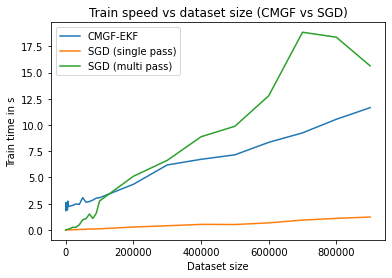

In [ ]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

In [ ]:
def compute_cv_accuracies(num_points, num_classes):
    input, output = make_classification(n_samples=num_points, n_features=num_classes+1, 
                                        n_informative=num_classes+1, n_redundant=0, n_classes=num_classes, random_state=2)
    scaler = preprocessing.StandardScaler().fit(input)
    input, output = jnp.array(scaler.transform(input)), jnp.array(output)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

    cmgf_est = CMGFOneVsAllEstimator(EKFParams)

    cmgf_score = cross_val_score(cmgf_est, input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_op_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()
    sag_mp_score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='sag'), input, output, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise').mean()

    return cmgf_score, sag_op_score, sag_mp_score

In [ ]:
num_points = 1000
class_range = range(2, 19)

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    cmgf_ac, sgd_op_ac, sgd_mp_ac = compute_cv_accuracies(num_points, num_classes)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sag estimate average accuracy = {sgd_op_ac}')
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sag estimate average accuracy = {sgd_mp_ac}')

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.9010000000000001
One-pass sag estimate average accuracy = 0.9
Multi-pass sag estimate average accuracy = 0.905
1000 data points, 3 classes.
EKF-CMGF estimate average accuracy = 0.625
One-pass sag estimate average accuracy = 0.585
Multi-pass sag estimate average accuracy = 0.628
1000 data points, 4 classes.
EKF-CMGF estimate average accuracy = 0.5359999999999999
One-pass sag estimate average accuracy = 0.46299999999999997
Multi-pass sag estimate average accuracy = 0.5489999999999998
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.491
One-pass sag estimate average accuracy = 0.449
Multi-pass sag estimate average accuracy = 0.483
1000 data points, 6 classes.
EKF-CMGF estimate average accuracy = 0.5680000000000001
One-pass sag estimate average accuracy = 0.537
Multi-pass sag estimate average accuracy = 0.5670000000000001
1000 data points, 7 classes.
EKF-CMGF estimate average accuracy = 0.451999999999999

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.376
One-pass sag estimate average accuracy = 0.33599999999999997
Multi-pass sag estimate average accuracy = 0.384
1000 data points, 9 classes.
EKF-CMGF estimate average accuracy = 0.45499999999999996
One-pass sag estimate average accuracy = 0.41900000000000004
Multi-pass sag estimate average accuracy = 0.4629999999999999
1000 data points, 10 classes.
EKF-CMGF estimate average accuracy = 0.399
One-pass sag estimate average accuracy = 0.36499999999999994
Multi-pass sag estimate average accuracy = 0.41
1000 data points, 11 classes.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.38699999999999996
One-pass sag estimate average accuracy = 0.36900000000000005
Multi-pass sag estimate average accuracy = 0.393
1000 data points, 12 classes.
EKF-CMGF estimate average accuracy = 0.357
One-pass sag estimate average accuracy = 0.331
Multi-pass sag estimate average accuracy = 0.365
1000 data points, 13 classes.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.336
One-pass sag estimate average accuracy = 0.30500000000000005
Multi-pass sag estimate average accuracy = 0.33999999999999997
1000 data points, 14 classes.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.341
One-pass sag estimate average accuracy = 0.29799999999999993
Multi-pass sag estimate average accuracy = 0.31900000000000006
1000 data points, 15 classes.
EKF-CMGF estimate average accuracy = 0.258
One-pass sag estimate average accuracy = 0.229
Multi-pass sag estimate average accuracy = 0.261
1000 data points, 16 classes.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.266
One-pass sag estimate average accuracy = 0.24699999999999997
Multi-pass sag estimate average accuracy = 0.272
1000 data points, 17 classes.
EKF-CMGF estimate average accuracy = 0.279
One-pass sag estimate average accuracy = 0.256
Multi-pass sag estimate average accuracy = 0.291
1000 data points, 18 classes.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


EKF-CMGF estimate average accuracy = 0.26799999999999996
One-pass sag estimate average accuracy = 0.229
Multi-pass sag estimate average accuracy = 0.25600000000000006


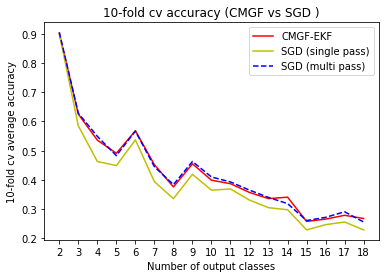

In [ ]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel('10-fold cv average accuracy')
ax.set_title('10-fold cv accuracy (CMGF vs SGD )')
ax.legend();